<a href="https://colab.research.google.com/github/AiNguyen2014/MachineLearningProject/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lưu ý

# Mình sẽ đánh giá essemble của train bằng silhoutte Và đánh giá external giữa independent với actual. Internal chỉ dùng để đánh giá train thôi

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

TARGET_FOLDER = "Project Machine Learning"
BASE_PATH = None

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if TARGET_FOLDER in dirs:
        BASE_PATH = os.path.join(root, TARGET_FOLDER)
        break

if BASE_PATH is None:
    raise FileNotFoundError(" Không tìm thấy thư mục Project Machine Learning")

print(" Dùng thư mục:", BASE_PATH)
print(" File trong thư mục:", os.listdir(BASE_PATH))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dùng thư mục: /content/drive/MyDrive/Project Machine Learning
 File trong thư mục: ['data_set_ALL_AML_train.csv', 'actual.csv', 'data_set_ALL_AML_independent.csv', 'train_scaled.csv', 'test_scaled.csv', 'train_processed.csv', 'test_processed.csv', 'data_processed_72_variance.csv', 'data_processed_optimal.csv', 'data_final_processed.csv', 'data_processed_72.csv', 'Machine Learning.ipynb']


# Setup môi trường

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
from sklearn.decomposition import PCA
import joblib
warnings.filterwarnings('ignore')

# Tải dữ liệu

In [ ]:
# Train & Independent: gene là index
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "data_set_ALL_AML_train.csv"),
    index_col=0
)

df_test = pd.read_csv(
    os.path.join(BASE_PATH, "data_set_ALL_AML_independent.csv"),
    index_col=0
)

# actual.csv: chỉ chứa nhãn → KHÔNG dùng index_col
df_actual = pd.read_csv(
    os.path.join(BASE_PATH, "actual.csv")
)

print("Train shape:", df_train.shape)
print("Independent shape:", df_test.shape)
print("Actual shape:", df_actual.shape)


Train shape: (7129, 77)
Independent shape: (7129, 69)
Actual shape: (72, 2)


# Tiền Xử Lý Dữ Liệu (Clean + Transpose + Z-score + PCA)

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA

# =============================
# CLEAN GENE EXPRESSION
# =============================
def clean_gene_expression(df):
    drop_cols = [
        col for col in df.columns
        if "Gene Description" in col
        or "Gene Accession Number" in col
        or "call" in col.lower()
    ]
    return df.drop(columns=drop_cols, errors="ignore")


df_train_clean = clean_gene_expression(df_train)
df_test_clean  = clean_gene_expression(df_test)

# =============================
# TRANSPOSE (samples × genes)
# =============================
X_train_raw = df_train_clean.T   # (38, genes)
X_test_raw  = df_test_clean.T    # (34, genes)

# =============================
# GỘP TOÀN BỘ 72 MẪU
# =============================
X_all_raw = pd.concat([X_train_raw, X_test_raw], axis=0)

print("Total samples after merge:", X_all_raw.shape)

# =============================
# Z-SCORE NORMALIZATION (ALL)
# =============================
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all_raw)

print("Scaled shape:", X_all_scaled.shape)

# =============================
# FEATURE SELECTION (SUPERVISED – CHỈ ĐỂ GIẢM CHIỀU)
# =============================
N_GENES = 200

# Tính variance từng gene
gene_variances = np.var(X_all_scaled, axis=0)

# Chọn top N_GENES variance cao nhất
top_gene_idx = np.argsort(gene_variances)[-N_GENES:]
X_all_fs = X_all_scaled[:, top_gene_idx]

print(f"Selected top {N_GENES} genes (unsupervised)")
print("After FS shape:", X_all_fs.shape)

# =============================
# SAVE FINAL DATASET (KHÔNG PCA)
# =============================
# Lấy tên cột từ top gene index để dễ hiểu (nếu muốn)
gene_cols = [f"Gene_{i+1}" for i in top_gene_idx]

X_all_out = pd.DataFrame(
    X_all_fs,
    index=X_all_raw.index,
    columns=gene_cols
)
X_all_out.insert(0, "Sample_ID", X_all_out.index)

X_all_out.to_csv(
    os.path.join(BASE_PATH, "data_processed_72.csv"),
    index=False
)

print("\n=== PREPROCESSING COMPLETE (NO PCA) ===")
print("Saved to: data_processed_72.csv", X_all_fs.shape)

Total samples after merge: (72, 7129)
Scaled shape: (72, 7129)
Selected top 200 genes (unsupervised)
After FS shape: (72, 200)

=== PREPROCESSING COMPLETE (NO PCA) ===
Saved to: data_processed_72.csv (72, 200)


# BASE MODELS - K-MEANS++

## Import thư viện cần thiết

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load dữ liệu đã chuẩn hóa

In [ ]:
# Đọc dữ liệu train đã được chuẩn hóa
try:
    train_path = os.path.join(BASE_PATH, 'data_processed_72.csv')
    train_df = pd.read_csv(train_path)
    print(f"Đã tải dữ liệu Train từ: {train_path}")
except Exception as e:
    print(f"Lỗi tải file: {e}")
    exit()

# Bỏ cột định danh không phải feature nếu tồn tại
if 'Sample_ID' in train_df.columns:
    train_df = train_df.drop(columns=['Sample_ID'])

# Chuyển thành numpy array
X_train = train_df.values  # hoặc train_df.to_numpy()


Đã tải dữ liệu Train từ: /content/drive/MyDrive/Project Machine Learning/data_processed_72.csv


In [ ]:
# Chuyển đổi DataFrame sang numpy array để tính toán
X = train_df.values
print(f"\nMảng dữ liệu X có shape: {X.shape}")


Mảng dữ liệu X có shape: (72, 200)


## Định nghĩa các hàm tính khoảng cách và inertia trong K means++

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def calculate_inertia(X, labels, centroids):
    return sum(
        np.sum((X[labels == i] - centroids[i]) ** 2)
        for i in range(len(centroids))
    )


In [ ]:
def kmeans_plusplus(X, k, max_iters=100, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    n = X.shape[0]

    # --- Khởi tạo centroids (K-Means++) ---
    centroids = [X[np.random.randint(n)]]
    for _ in range(1, k):
        dist = np.min(
            np.array([[euclidean_distance(x, c) for c in centroids] for x in X]),
            axis=1
        )
        probs = dist**2 / np.sum(dist**2)
        centroids.append(X[np.random.choice(n, p=probs)])
    centroids = np.array(centroids)

    # --- Iterative optimization ---
    for _ in range(max_iters):
        labels = np.argmin(
            np.linalg.norm(X[:, None] - centroids[None, :], axis=2),
            axis=1
        )
        new_centroids = np.array([
            X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
            for i in range(k)
        ])
        if np.allclose(centroids, new_centroids, atol=tol):
            break
        centroids = new_centroids

    return labels, centroids


## BƯỚC 1: ĐÁNH GIÁ & LỰA CHỌN SỐ CỤM K TỐI ƯU
**Thực hiện:** Chạy K-means++ với K từ 2 đến 10, so sánh Silhouette Score, chọn K tốt nhất

In [ ]:
print("=== CHỌN K BẰNG SILHOUETTE ===")
k_range = range(2, 11)
sil_scores = []

for k in k_range:
    labels, _ = kmeans_plusplus(X, k)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)
    print(f"K={k}: Silhouette={sil:.4f}")

best_k = k_range[np.argmax(sil_scores)]
print(f"\n→ Chọn K tối ưu = {best_k}")

=== CHỌN K BẰNG SILHOUETTE ===
K=2: Silhouette=0.0925
K=3: Silhouette=0.0272
K=4: Silhouette=0.0254
K=5: Silhouette=0.0521
K=6: Silhouette=0.0681
K=7: Silhouette=0.0594
K=8: Silhouette=0.0721
K=9: Silhouette=0.0446
K=10: Silhouette=0.0302

→ Chọn K tối ưu = 2


In [ ]:
labels_final, centroids_final = kmeans_plusplus(X, best_k)

## ĐÁNH GIÁ KẾT QUẢ MÔ HÌNH TRÊN DỮ LIỆU TRAIN

In [ ]:
final_sil = silhouette_score(X, labels_final)
final_inertia = calculate_inertia(X, labels_final, centroids_final)

print("\n=== ĐÁNH GIÁ K-MEANS++ ===")
print(f"Số mẫu: {X.shape[0]}")
print(f"Số chiều: {X.shape[1]}")
print(f"Số cụm (K): {best_k}")
print(f"Silhouette Score: {final_sil:.4f}")
print(f"Inertia (SSE): {final_inertia:.2f}")

print("\nPhân bố cụm:")
for i in range(best_k):
    print(f"  Cụm {i}: {(labels_final == i).sum()} samples")


=== ĐÁNH GIÁ K-MEANS++ ===
Số mẫu: 72
Số chiều: 200
Số cụm (K): 2
Silhouette Score: 0.0925
Inertia (SSE): 13108.45

Phân bố cụm:
  Cụm 0: 44 samples
  Cụm 1: 28 samples


# BASE MODELS - HIERARCHICAL

# **Xây dựng mô hình (Training) và đánh giá nội bộ (chưa đụng đến tập Test hay so sánh với thực tế)**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import os

# ============================================================
# PHẦN 1: BASE LEARNER - HIERARCHICAL CLUSTERING
# ============================================================

class HierarchicalClustering:
    def __init__(self, n_clusters=2, linkage='ward'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels_ = None

    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def _compute_distance_matrix(self, X):
        n = X.shape[0]
        dist_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                dist = self._euclidean_distance(X[i], X[j])
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
        return dist_matrix

    # --- Linkage Functions ---
    def _single_linkage(self, c1_idxs, c2_idxs, dist_matrix):
        min_dist = float('inf')
        for i in c1_idxs:
            for j in c2_idxs:
                if dist_matrix[i, j] < min_dist: min_dist = dist_matrix[i, j]
        return min_dist

    def _complete_linkage(self, c1_idxs, c2_idxs, dist_matrix):
        max_dist = 0
        for i in c1_idxs:
            for j in c2_idxs:
                if dist_matrix[i, j] > max_dist: max_dist = dist_matrix[i, j]
        return max_dist

    def _ward_linkage(self, c1_idxs, c2_idxs, X):
        m1 = np.mean(X[c1_idxs], axis=0)
        m2 = np.mean(X[c2_idxs], axis=0)
        n1, n2 = len(c1_idxs), len(c2_idxs)
        return np.sqrt((2 * n1 * n2) / (n1 + n2)) * self._euclidean_distance(m1, m2)

    def _cluster_distance(self, c1_idxs, c2_idxs, dist_matrix, X):
        if self.linkage == 'single': return self._single_linkage(c1_idxs, c2_idxs, dist_matrix)
        elif self.linkage == 'complete': return self._complete_linkage(c1_idxs, c2_idxs, dist_matrix)
        elif self.linkage == 'ward': return self._ward_linkage(c1_idxs, c2_idxs, X)

    def fit(self, X):
        n_samples = X.shape[0]
        clusters = {i: [i] for i in range(n_samples)}

        dist_matrix = None
        if self.linkage != 'ward':
            dist_matrix = self._compute_distance_matrix(X)

        while len(clusters) > self.n_clusters:
            min_dist = float('inf')
            merge_pair = None
            ids = list(clusters.keys())

            # Tìm cặp gần nhất
            for i in range(len(ids)):
                for j in range(i+1, len(ids)):
                    id1, id2 = ids[i], ids[j]
                    dist = self._cluster_distance(clusters[id1], clusters[id2], dist_matrix, X)
                    if dist < min_dist:
                        min_dist = dist
                        merge_pair = (id1, id2)

            # Gộp
            c1, c2 = merge_pair
            new_id = max(ids) + 1
            clusters[new_id] = clusters[c1] + clusters[c2]
            del clusters[c1]; del clusters[c2]

        # Lưu nhãn cuối cùng
        self.labels_ = np.zeros(n_samples, dtype=int)
        for idx, (cid, members) in enumerate(clusters.items()):
            self.labels_[members] = idx
        return self

# ============================================================
# PHẦN 2: CHUẨN BỊ CHO ENSEMBLE (BASE LEARNERS)
# ============================================================

if __name__ == "__main__":
    # 1. Load Data
    try:
        train_path = os.path.join(BASE_PATH, 'data_processed_72.csv')
        train_df = pd.read_csv(train_path)
        X_train = train_df.drop('Sample_ID', axis=1, errors='ignore').values
        print(f" Đã tải dữ liệu: {X_train.shape}")
    except Exception as e:
        print(f"Lỗi: {e}"); exit()

    # 2. Tạo tập hợp các Base Learners (Đa dạng hóa bằng Linkage)
    # Lưu ý quan trọng: n_clusters=2 (Chuẩn bài toán ung thư)
    linkages = ['single', 'complete', 'ward']
    base_models = {}

    print("\n ĐANG XÂY DỰNG CÁC BASE LEARNERS...")

    for link in linkages:
        print(f"   -> Training {link.upper()} model...")
        model = HierarchicalClustering(n_clusters=2, linkage=link)
        model.fit(X_train)

        # Lưu model vào dictionary để dùng cho Ensemble sau này
        base_models[link] = model

        # Đánh giá nhanh chất lượng từng model con
        sil = silhouette_score(X_train, model.labels_)
        print(f"      (Silhouette: {sil:.4f})")

    print(f"\n Đã chuẩn bị xong {len(base_models)} mô hình cơ sở cho Ensemble!")
    print(f"   Danh sách: {list(base_models.keys())}")

 Đã tải dữ liệu: (72, 200)

 ĐANG XÂY DỰNG CÁC BASE LEARNERS...
   -> Training SINGLE model...
      (Silhouette: 0.3360)
   -> Training COMPLETE model...
      (Silhouette: 0.3527)
   -> Training WARD model...
      (Silhouette: 0.0658)

 Đã chuẩn bị xong 3 mô hình cơ sở cho Ensemble!
   Danh sách: ['single', 'complete', 'ward']


# BASE MODELS - GMM

Dataset shape: (72, 200)
Cluster labels: [0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1]

INTERNAL VALIDATION (GMM - 72 samples)
Silhouette: 0.1392
Davies–Bouldin: 3.0138


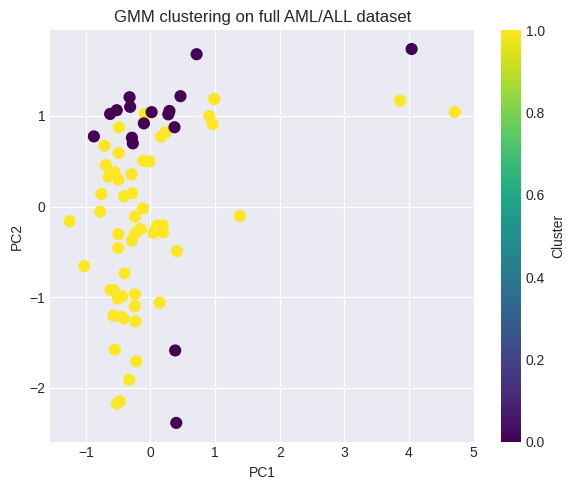

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.metrics import silhouette_score, davies_bouldin_score

# ============================================================
# LOAD DATA (72 samples - AFTER PREPROCESSING)
# ============================================================

df = pd.read_csv(os.path.join(BASE_PATH, "data_processed_72.csv"))
X = df.drop(columns=["Sample_ID"], errors="ignore").values

print("Dataset shape:", X.shape)


# ============================================================
# GMM WITH DIAGONAL COVARIANCE (STABLE VERSION)
# ============================================================

class GMM:
    def __init__(self, n_components=2, max_iter=100, tol=1e-4, reg=1e-3):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg = reg

    def gaussian_diag(self, X, mean, var):
        d = X.shape[1]
        var = var + self.reg
        diff = X - mean
        log_prob = -0.5 * (
            np.sum(np.log(2 * np.pi * var)) +
            np.sum((diff ** 2) / var, axis=1)
        )
        return np.exp(log_prob)

    def fit(self, X):
        n, d = X.shape
        rng = np.random.default_rng(42)

        # Initialization
        self.means = X[rng.choice(n, self.K, replace=False)]
        self.vars = np.array([np.var(X, axis=0) for _ in range(self.K)])
        self.weights = np.ones(self.K) / self.K

        prev_ll = None

        for _ in range(self.max_iter):
            resp = np.zeros((n, self.K))

            # E-step
            for k in range(self.K):
                resp[:, k] = self.weights[k] * self.gaussian_diag(
                    X, self.means[k], self.vars[k]
                )

            resp_sum = resp.sum(axis=1, keepdims=True)
            resp_sum[resp_sum == 0] = 1e-10
            resp /= resp_sum

            Nk = resp.sum(axis=0)

            # M-step
            for k in range(self.K):
                self.means[k] = np.sum(resp[:, k][:, None] * X, axis=0) / Nk[k]
                diff = X - self.means[k]
                self.vars[k] = np.sum(resp[:, k][:, None] * (diff ** 2), axis=0) / Nk[k]
                self.weights[k] = Nk[k] / n

            ll = np.sum(np.log(resp_sum))
            if prev_ll is not None and abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll

    def predict(self, X):
        probs = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            probs[:, k] = self.weights[k] * self.gaussian_diag(
                X, self.means[k], self.vars[k]
            )
        return np.argmax(probs, axis=1)


# ============================================================
# TRAIN GMM ON FULL DATASET
# ============================================================

gmm = GMM(n_components=2)
gmm.fit(X)

labels = gmm.predict(X)

print("Cluster labels:", labels)


# ============================================================
# INTERNAL VALIDATION
# ============================================================

sil = silhouette_score(X, labels)
db  = davies_bouldin_score(X, labels)

print("\nINTERNAL VALIDATION (GMM - 72 samples)")
print("Silhouette:", round(sil, 4))
print("Davies–Bouldin:", round(db, 4))


# ============================================================
# VISUALIZATION (PCA SPACE)
# ============================================================

X_vis = X[:, :2]

plt.figure(figsize=(6, 5))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=labels, cmap="viridis", s=60)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("GMM clustering on full AML/ALL dataset")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()


# ============================================================
# OUTPUT FOR ENSEMBLE
# ============================================================

gmm_labels_all = labels


# ENSEMBLE CLUSTERING

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Đang lấy nhãn từ 3 Base Models ---")

# 1. Base models

labels_km, centroids_km = kmeans_plusplus(X_all_fs, k=2, random_state=42)

bu_model.fit(X_all)
labels_bu = bu_model.labels_

gmm_model.fit(X_all)
labels_gmm = gmm_model.predict(X_all)

score = silhouette_score(X_all, ensemble_labels)

print("Đã thu thập xong nhãn từ K-means++, Bottom-up và GMM.")

# 2. Weights
weights = {
    "kmeans": 0.3,
    "hierarchical": 0.6,
    "gmm": 0.1
}

labels_dict = {
    "kmeans": labels_km,
    "hierarchical": labels_bu,
    "gmm": labels_gmm
}

# ============================================================
# 3. BUILD WEIGHTED CO-ASSOCIATION MATRIX
# ============================================================
def build_weighted_co_association_matrix(labels_dict, weights):
    model_names = list(labels_dict.keys())
    n_samples = len(labels_dict[model_names[0]])

    co_matrix = np.zeros((n_samples, n_samples))
    total_weight = sum(weights.values())

    for name in model_names:
        labels = labels_dict[name]
        w = weights[name]

        for i in range(n_samples):
            for j in range(i, n_samples):
                if labels[i] == labels[j]:
                    co_matrix[i, j] += w
                    if i != j:
                        co_matrix[j, i] += w

    return co_matrix / total_weight


print("\n--- Đang xây dựng Weighted Co-association Matrix ---")
co_matrix = build_weighted_co_association_matrix(labels_dict, weights)

# ============================================================
# 4. FINAL ENSEMBLE CLUSTERING
# ============================================================
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

def ensemble_final_step(co_matrix, n_clusters=2):
    # Similarity → Distance
    dist_matrix = 1 - co_matrix

    condensed_dist = squareform(dist_matrix, checks=False)
    Z = linkage(condensed_dist, method='average')

    final_labels = fcluster(Z, t=n_clusters, criterion='maxclust') - 1
    return final_labels, Z


print("--- Đang thực hiện Final Hierarchical Clustering ---")
ensemble_labels, linkage_matrix = ensemble_final_step(co_matrix, n_clusters=2)

# ============================================================
# 5. EVALUATION
# ============================================================
from sklearn.metrics import silhouette_score

score = silhouette_score(X_train, ensemble_labels)

print("\n" + "="*50)
print("KẾT QUẢ ENSEMBLE CLUSTERING (KM++ + BU + GMM)")
print("="*50)
print(f"Final Silhouette Score: {score:.4f}")
print(f"Nhãn cụm cuối cùng: {ensemble_labels}")

# ============================================================
# 6. VISUALIZATION
# ============================================================
plt.figure(figsize=(8, 6))
sns.heatmap(co_matrix, cmap='YlGnBu')
plt.title("Weighted Co-association Matrix")
plt.show()

plt.figure(figsize=(10, 5))
from scipy.cluster.hierarchy import dendrogram
dendrogram(linkage_matrix)
plt.title("Ensemble Dendrogram")
plt.show()

# ============================================================
# 7. EXTERNAL EVALUATION
# ============================================================

df_actual = pd.read_csv(
    os.path.join(BASE_PATH, "actual.csv")
)

X_train_patient_ids = list(range(1, 39))  # nếu bệnh nhân train là 1-38

# Lọc nhãn train
train_actual = df_actual[df_actual['patient'].isin(X_train_patient_ids)]

# Map nhãn sang 0/1
y_true = train_actual['cancer'].map({'AML': 0, 'ALL': 1}).values

# Kiểm tra
print("Train y_true shape:", y_true.shape)
print(y_true)


from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def purity_score(y_true, y_pred):
    # Purity = sum(max count in cluster) / total samples
    contingency_matrix = np.zeros((np.max(y_pred)+1, np.max(y_true)+1))
    for i in range(len(y_true)):
        contingency_matrix[y_pred[i], y_true[i]] += 1
    return np.sum(np.max(contingency_matrix, axis=1)) / np.sum(contingency_matrix)

# y_true = nhãn thực tế ALL/AML từ actual.csv, dạng integer 0/1
# Giả sử mày đã encode nhãn thành 0 = AML, 1 = ALL

base_models = {
    "KMeans++": labels_km,
    "Hierarchical": labels_bu,
    "GMM": labels_gmm,
    "Ensemble": ensemble_labels
}

print("\n--- EXTERNAL EVALUATION (Train) ---")
for name, labels in base_models.items():
    ari = adjusted_rand_score(y_true, labels)
    nmi = normalized_mutual_info_score(y_true, labels)
    pur = purity_score(y_true, labels)
    print(f"{name}: ARI={ari:.4f}, NMI={nmi:.4f}, Purity={pur:.4f}")


--- Đang lấy nhãn từ 3 Base Models ---


NameError: name 'bu_model' is not defined

#  TEST ON INDEPENDENT

In [ ]:
import pandas as pd
import numpy as np
import os

# Load test
df_test = pd.read_csv(os.path.join(BASE_PATH, "test_processed.csv"))
X_test = df_test.values
# Hoặc nếu có cột Sample_ID:
X_test = df_test.drop(columns=["Sample_ID"], errors="ignore").values



print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
X_all = np.vstack([X_train, X_test])
n_train = X_train.shape[0]
n_test = X_test.shape[0]

print("X_all shape:", X_all.shape)
print("\n--- BASE MODELS trên TRAIN + TEST ---")

# KMeans++
labels_km_all, _, _ = kmeans_plusplus(
    X_all,
    k=2,
    random_state=42
)

# Hierarchical
bu_all = HierarchicalClustering(n_clusters=2, linkage='ward')
bu_all.fit(X_all)
labels_bu_all = bu_all.labels_

# GMM
gmm_all = GMM(n_components=2)
gmm_all.fit(X_all)
labels_gmm_all = gmm_all.predict(X_all)

print("Đã lấy xong nhãn KMeans++, Hierarchical, GMM cho toàn bộ data.")
weights = {
    "kmeans": 0.3,
    "hierarchical": 0.6,
    "gmm": 0.1
}

labels_dict_all = {
    "kmeans": labels_km_all,
    "hierarchical": labels_bu_all,
    "gmm": labels_gmm_all
}

def build_weighted_co_association_matrix(labels_dict, weights):
    model_names = list(labels_dict.keys())
    n_samples = len(labels_dict[model_names[0]])

    co_matrix = np.zeros((n_samples, n_samples))
    total_weight = sum(weights.values())

    for name in model_names:
        labels = labels_dict[name]
        w = weights[name]

        for i in range(n_samples):
            for j in range(i, n_samples):
                if labels[i] == labels[j]:
                    co_matrix[i, j] += w
                    if i != j:
                        co_matrix[j, i] += w

    return co_matrix / total_weight


print("\n--- Xây dựng EXTENDED Co-association Matrix ---")
co_matrix_all = build_weighted_co_association_matrix(labels_dict_all, weights)

print("Co-association shape:", co_matrix_all.shape)
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

def ensemble_final_step(co_matrix, n_clusters=2):
    dist_matrix = 1 - co_matrix
    condensed_dist = squareform(dist_matrix, checks=False)
    Z = linkage(condensed_dist, method='average')
    final_labels = fcluster(Z, t=n_clusters, criterion='maxclust') - 1
    return final_labels, Z


print("\n--- CONSENSUS CLUSTERING trên EXTENDED MATRIX ---")
ensemble_labels_all, linkage_matrix_all = ensemble_final_step(
    co_matrix_all,
    n_clusters=2
)

labels_train_final = ensemble_labels_all[:n_train]
labels_test_final  = ensemble_labels_all[n_train:]

print("Train ensemble labels shape:", labels_train_final.shape)
print("Test ensemble labels shape:", labels_test_final.shape)
df_actual = pd.read_csv(os.path.join(BASE_PATH, "actual.csv"))

# Train: patient 1–38
train_actual = df_actual[df_actual['patient'].between(1, 38)]
y_train_true = train_actual['cancer'].map({'AML': 0, 'ALL': 1}).values

# Test: patient 39–72
test_actual = df_actual[df_actual['patient'].between(39, 72)]
y_test_true = test_actual['cancer'].map({'AML': 0, 'ALL': 1}).values
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def purity_score(y_true, y_pred):
    contingency = np.zeros((np.max(y_pred)+1, np.max(y_true)+1))
    for i in range(len(y_true)):
        contingency[y_pred[i], y_true[i]] += 1
    return np.sum(np.max(contingency, axis=1)) / np.sum(contingency)


print("\n--- EXTERNAL EVALUATION (EXTENDED ENSEMBLE) ---")

print("TRAIN:")
print("ARI:", adjusted_rand_score(y_train_true, labels_train_final))
print("NMI:", normalized_mutual_info_score(y_train_true, labels_train_final))
print("Purity:", purity_score(y_train_true, labels_train_final))

print("\nTEST:")
print("ARI:", adjusted_rand_score(y_test_true, labels_test_final))
print("NMI:", normalized_mutual_info_score(y_test_true, labels_test_final))
print("Purity:", purity_score(y_test_true, labels_test_final))


#  EVALUATION